In [95]:
#This notebook reproduces analyses and graphs for Figures 6a-c from "A data compendium of Mycobacteriumtuberculosis antibiotic resistance"

#ENTER LOCAL FILE PATH TO CRYPTIC TABLES
file_path='../example/file/path'

# imports
import pandas as pd
import numpy as np
import os


from statsmodels.stats.proportion import proportions_ztest

#for figures
import geopandas
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

In [96]:
def z_test(sample_success_a, sample_size_a, sample_success_b, sample_size_b):
    '''runs two tailed z test to compare two percentages. 
    Input = positive samples from A, sample size A, positivie samples from B, sample size B
    Returns = p value'''

    significance = 0.05


    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])

    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    # report
    print(sample_success_a/sample_size_a*100, sample_success_b/sample_size_b*100,)
    print('z_stat: %0.5f, p_value: %0.5f' % (stat, p_value))
    if p_value > significance:
        print ("Fail to reject the null hypothesis - we have nothing else to say")
    else:
        print ("Reject the null hypothesis - suggest the alternative hypothesis is true")
    return(p_value)

In [97]:
#read in isolates with WGS data, file contains lineage information
genomes = pd.read_pickle(file_path+"/GENOMES.pkl.gz")
genomes.reset_index(level=0, inplace=True)
genomes=genomes.loc[(genomes.BELONGS_GPI==True)&(genomes.SITEID!='QC') ]

In [98]:
#read in sample information and table to interpret country codes
countries = pd.read_csv(file_path+"/COUNTRIES_LOOKUP.csv")
samples = pd.read_pickle(file_path+"/SAMPLES.pkl.gz")
samples.reset_index(level=2, inplace=True)
samples.reset_index(level=1, inplace=True)
samples.reset_index(level=0, inplace=True)

In [99]:
#read in phenotypes data
phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
phenotypes.reset_index(level=1, inplace=True)
phenotypes.reset_index(level=0, inplace=True)
phenotypes=phenotypes.loc[(phenotypes.BELONGS_GPI==True)]

#assign R/S to INH isolates using ECOFFs from The CRyPTIC Consortium, European Respiratory Journal 2022; DOI: 10.1183/13993003.00239-2022
phenotypes.loc[((phenotypes['DRUG'] =='INH')&(phenotypes['BINARY_PHENOTYPE']=='I')), 'BINARY_PHENOTYPE'] = 'R'

In [100]:
#read in isolates rpob mutations
mutations=pd.read_pickle(file_path+"/MUTATIONS_GPI.pkl.gz")
mutations.reset_index(inplace=True)
rpob_mutations=mutations.loc[mutations.GENE.isin(['rpoB'])]

In [101]:
#get dataframes for isolates phenotypes to rifampicin and isoniazid
rif_p=phenotypes.loc[(phenotypes['DRUG']=='RIF')]
inh_p=phenotypes.loc[(phenotypes['DRUG']=='INH')]
#merge rifampin and isoniazid dataframes and remove isolates without an MIC reading for one or both drugs
randi_p=pd.merge(rif_p, inh_p, how='left', on=['UNIQUEID'])
randi_p=randi_p.loc[(randi_p['BINARY_PHENOTYPE_x'].notna())&(randi_p['BINARY_PHENOTYPE_y'].notna())]

In [102]:
#calculate number monoR
monoR=(randi_p.loc[(randi_p['BINARY_PHENOTYPE_x']=='R')&(randi_p['BINARY_PHENOTYPE_y']=='S')])
no_monoR=len(monoR)
print('RMR isolates = ', no_monoR)
#calculate number MDR
mdr=(randi_p.loc[(randi_p['BINARY_PHENOTYPE_x']=='R')&((randi_p['BINARY_PHENOTYPE_y']=='R'))])
no_mdr=len(mdr)
print('MDR isolates = ', no_mdr)
#percent monoR
print('% RIF R isolates that are RMR = ', no_monoR/(no_mdr+no_monoR)*100)

RMR isolates =  302
MDR isolates =  4353
% RIF R isolates that are RMR =  6.48764769065521


In [103]:
#merge sample uniqueids and country information
gs = pd.merge(genomes, samples, how='left', on=['SITEID','SUBJID','LABID'])

#make dataframe with country information for RMR samples, count number of samples from each country
countries_df_rmr = pd.merge(monoR, gs, how='left', on='UNIQUEID')
rmr_countries_vcs=countries_df_rmr.COUNTRY_WHERE_SAMPLE_TAKEN.value_counts()

#make dataframe with country information for MDR samples, count number of samples from each country
countries_df_mdr = pd.merge(mdr, gs, how='left', on='UNIQUEID')
mdr_countries_vcs=countries_df_mdr.COUNTRY_WHERE_SAMPLE_TAKEN.value_counts()


In [68]:
def country_z_test(country):
     '''given a country code, function returns p value for z test comparing proportion RMR in given country to proportion of the total dataset'''
    print(country)
    z_test(rmr_countries_vcs[country],(rmr_countries_vcs[country]+mdr_countries_vcs[country]),no_monoR,no_mdr+no_monoR)
    return( z_test(rmr_countries_vcs[country],(rmr_countries_vcs[country]+mdr_countries_vcs[country]),no_monoR,no_mdr+no_monoR))

In [69]:
#make lists from RMR and MDR country value counts to turn into dataframe
rmr_numbers_list=[no_monoR]
mdr_numbers_list=[no_mdr]
rmr_countries_list=['TOTAL']
for i in rmr_countries_vcs.index:
    if rmr_countries_vcs[i]>0:
        rmr_numbers_list.append(rmr_countries_vcs[i])
        rmr_countries_list.append(i)
        mdr_numbers_list.append(mdr_countries_vcs[i])

#make list of p values for z tests for difference between proportion RMR in given country to proportion of the total dataset
p_list=[np.nan]
for i in rmr_countries_list[1:]:
    p_list.append(country_z_test(i))

In [71]:
#create dataframe of country, number of RMR samples, number of MDR samples, p values fro z tests and RMR samples as a percentage of all rifampicin resistant samples
rmr_geo_df=pd.DataFrame(list(zip(rmr_countries_list, rmr_numbers_list, mdr_numbers_list, p_list)),columns =['COUNTRY', 'NO_RMR','NO_MDR','P'])
rmr_geo_df['RMR_%']=rmr_geo_df['NO_RMR']/(rmr_geo_df['NO_RMR']+rmr_geo_df['NO_MDR'])*100
rmr_geo_df

,COUNTRY,NO_RMR,NO_MDR,P,RMR_%
0,TOTAL,302,4353,NaN,6.487648
1,ZAF,114,539,1.543876e-22,17.457887
2,PER,46,795,2.645953e-01,5.469679
3,IND,18,751,6.140803e-06,2.340702
4,ITA,13,205,7.582926e-01,5.963303
5,CHN,11,263,1.028204e-01,4.014599
6,PAK,9,376,1.144854e-03,2.337662
7,BRA,9,72,9.581751e-02,11.111111
8,VNM,8,106,8.206304e-01,7.017544
9,DEU,4,80,5.235801e-01,4.761905


In [72]:
#merge data frame with country code identifiers
rmr_geo_df_cn=pd.merge(rmr_geo_df, countries, how='left', left_on='COUNTRY',right_on='COUNTRY_CODE_3_LETTER')
rmr_geo_df_cn=rmr_geo_df_cn.sort_values(by='COUNTRY_NAME', ascending=False)
rmr_geo_df_cn=rmr_geo_df_cn.replace({'COUNTRY_NAME': {np.nan: 'TOTAL'}})

<ipython-input-73-d0beb4790ebb>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('rmr_countries_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


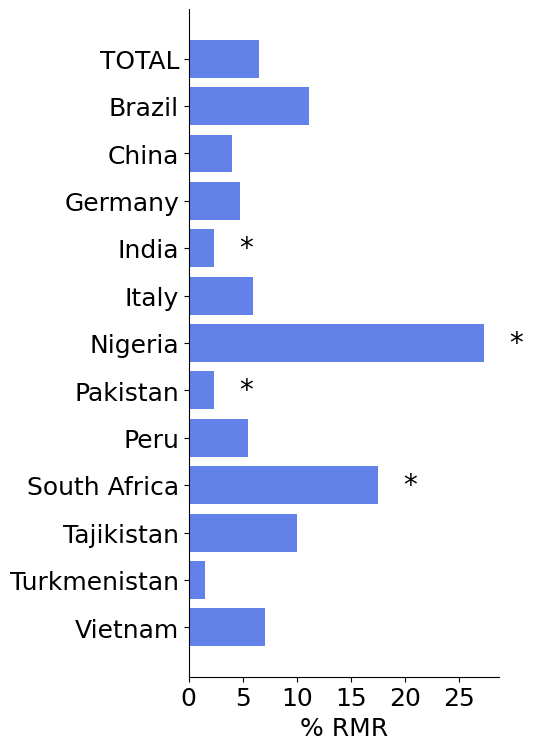

In [73]:
#make RMR prevalence graph
plt.figure(figsize=(4,len(rmr_geo_df)/1.5))
plt.barh(rmr_geo_df_cn.COUNTRY_NAME,rmr_geo_df_cn['RMR_%'], color='#6282ea')
plt.xticks(size=18)
plt.yticks(size=18)
plt.xticks(size=18)
plt.xlabel('% RMR', size=18)
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 
for i in range(0,len(rmr_geo_df_cn)):
    if rmr_geo_df_cn['P'].values[i]<=0.025:
        plt.text(rmr_geo_df_cn['RMR_%'].values[i]+3, i, '*', ha = 'center', va='center', size=20)

plt.savefig('rmr_countries_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')

In [74]:
#make dataframes of RMR/MDR samples and their rpob mutations
monoR_muts=pd.merge(monoR, rpob_mutations, how='left', on=['UNIQUEID'])
mdr_muts=pd.merge(mdr, rpob_mutations, how='left', on=['UNIQUEID'])

In [105]:
#calculate number of monoR isolates with a rrdr mutation
monoR_rrdr_muts=monoR_muts.loc[((monoR_muts['POSITION']>=426) & (monoR_muts['POSITION']<=452)) 
                               & (monoR_muts['IS_SYNONYMOUS']==False)]
monoR_rrdr_mut_isolates=monoR_rrdr_muts.UNIQUEID.unique()
print("Number of RMR isolates with rpob RRDR mutation = ",len(monoR_rrdr_mut_isolates))
#calculate number of monoR isolates with rpob mutation outside RRDR
monoR_nonrrdr_muts=monoR_muts.loc[((monoR_muts['POSITION']<426) | (monoR_muts['POSITION']>452))&
                                 (monoR_muts['IS_SYNONYMOUS']==False)]
monoR_nonrrdr_mut_isolates=monoR_nonrrdr_muts.UNIQUEID.unique()
len(monoR_nonrrdr_mut_isolates)
#caclulate no of isolate with rpob mutations outside RRDR and none inside RRDR
monoR_outside_rrdr_only=[]
for i in monoR_nonrrdr_mut_isolates:
    if i not in monoR_rrdr_mut_isolates:
        monoR_outside_rrdr_only.append(i)
print("Number of RMR isolates with only rpob mutation outside RRDR =",len(monoR_outside_rrdr_only))
#calculate number of monoR isolates with no rpob mutation
print("Number of RMR isolates with no rpob mutation =", len(monoR)-len(monoR_outside_rrdr_only)-len(monoR_rrdr_mut_isolates))

Number of RMR isolates with rpob RRDR mutation =  276
Number of RMR isolates with only rpob mutation outside RRDR = 10
Number of RMR isolates with no rpob mutation = 16


In [106]:
#number of MDR isolates with a rrdr mutation
mdr_rrdr_muts=mdr_muts.loc[((mdr_muts['POSITION']>=426) & (mdr_muts['POSITION']<=452)) 
                           & (mdr_muts['IS_SYNONYMOUS']==False)]
mdr_rrdr_mut_isolates=mdr_rrdr_muts.UNIQUEID.unique()
print("Number of MDR isolates with rpob RRDR mutation = ",len(mdr_rrdr_mut_isolates))
#number of monoR isolates with rpob mutation outside RRDR
mdr_nonrrdr_muts=mdr_muts.loc[((mdr_muts['POSITION']<426) | (mdr_muts['POSITION']>452))
                              & (mdr_muts['IS_SYNONYMOUS']==False)]
mdr_nonrrdr_mut_isolates=mdr_nonrrdr_muts.UNIQUEID.unique()
len(mdr_nonrrdr_mut_isolates)
#no of isolate with rpob mutations outside RRDR and none inside RRDR
mdr_outside_rrdr_only=[]
for i in mdr_nonrrdr_mut_isolates:
    if i not in mdr_rrdr_mut_isolates:
        mdr_outside_rrdr_only.append(i)
print("Number of MDR isolates with only rpob mutation outside RRDR = ",len(mdr_outside_rrdr_only))
#number of mdr isolates with no rpob mutation
print("Number of MDR isolates with no rpob mutation = ", len(mdr)-len(mdr_outside_rrdr_only)-len(mdr_rrdr_mut_isolates))

Number of MDR isolates with rpob RRDR mutation =  4166
Number of MDR isolates with only rpob mutation outside RRDR =  110
Number of MDR isolates with no rpob mutation =  77


<ipython-input-107-0c0a1c481fe8>:51: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-107-0c0a1c481fe8>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('genexpert_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


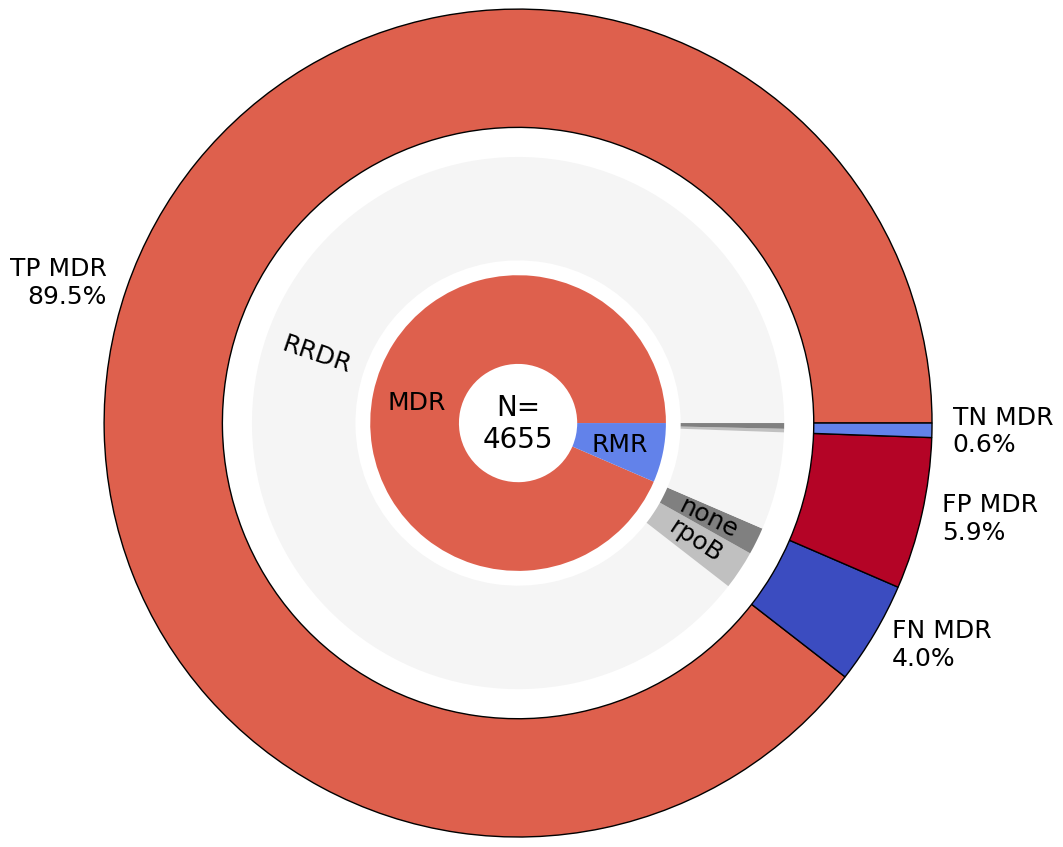

In [107]:
# Make graph showing performance of in silico Xpert for detecting MDR in rifampicin resistant isolates in CRyPTIC

 

group_names=['MDR', 'RMR']
group_size=[no_mdr,no_monoR]
subgroup_names=['RRDR', 'rpoB', 'none', '', '', '']
subgroup_size=[len(mdr_rrdr_mut_isolates),len(mdr_outside_rrdr_only),
               no_mdr-len(mdr_outside_rrdr_only)-len(mdr_rrdr_mut_isolates),
               len(monoR_rrdr_mut_isolates),len(monoR_outside_rrdr_only),
               no_monoR-len(monoR_outside_rrdr_only)-len(monoR_rrdr_mut_isolates)]
correct=(len(mdr_rrdr_mut_isolates)/(no_mdr+no_monoR))*100
not_mdr=(no_monoR-len(monoR_rrdr_mut_isolates))/(no_mdr+no_monoR)*100
fp=((len(monoR_rrdr_mut_isolates))/(no_mdr+no_monoR))*100
fn=((len(mdr_outside_rrdr_only)+ 
     no_mdr-len(mdr_outside_rrdr_only)-len(mdr_rrdr_mut_isolates))/(no_mdr+no_monoR))*100
subgroup2_names=["TP MDR\n"+str(round(correct,1))+'%', "FN MDR\n"+str(round(fn,1))+'%', "FP MDR\n"+str(round(fp,1))+'%', 
                 "TN MDR\n"+str(round(not_mdr,1))+'%']
subgroup2_size=[len(mdr_rrdr_mut_isolates),
                (len(mdr_outside_rrdr_only)+ 
                 no_mdr-len(mdr_outside_rrdr_only)-len(mdr_rrdr_mut_isolates)),
                 len(monoR_rrdr_mut_isolates),no_monoR-len(monoR_rrdr_mut_isolates)]
  
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=0.8+0.2, labels=group_names, labeldistance=0.7, textprops=dict(color="k",size=18, horizontalalignment='center', verticalalignment='center'),
                  colors=['#de604d', '#6282ea'])
plt.setp( mypie, width=0.6)
 
# Second Ring 
mypie2, _ = ax.pie(subgroup_size, radius=0.8+1, labels=subgroup_names, labeldistance=0.8, colors=['whitesmoke', 'silver', 'gray', 'whitesmoke',
                                                          'silver', 'gray'], rotatelabels=True, textprops=dict(color="k",size=18,horizontalalignment='center', verticalalignment='center'))
plt.setp( mypie2, width=0.7)
plt.margins(0,0)

# Third Ring 
mypie2, _ = ax.pie(subgroup2_size, radius=0.8+2, labels=subgroup2_names, labeldistance=1.05, textprops=dict(color='k',size=18),
                   colors=['#de604d', '#3b4cc0','#b40426', '#6282ea'], wedgeprops=dict(width=0.005, edgecolor='k'))
plt.setp( mypie2, width=0.8)
plt.margins(0,0)

plt.text(0,0,"N=\n"+str(no_mdr+no_monoR), horizontalalignment='center', verticalalignment='center', size=20)


fig.tight_layout()
plt.savefig('genexpert_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')

In [108]:
#make dict for y axis positions of mutant amino acids
aas_dict={'A': 1,'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7,
                 'I':8, 'K':9, 'L':10, 'M':11, 'N':12,'P':13, 
                  'Q':14, 'R':15, 'S':16, 'T': 17,'V': 18, 
                  'W':19, 'Y':20, 'promoter SNP':21,'indel':22
                 }

In [109]:

def get_new_aa(index):
    '''Given an index from dataframe.MUTATION.value_counts(), returns mutant amino acid (or promoter SNP or indel status)'''
    new_aa=[]
    for item in index:
        if item[-1] in aas_dict.keys():
            new_aa.append(item[-1])
        elif item[-1] in ['a','t','c','g']:
             new_aa.append("promoter SNP")
        elif item[-1] == 'l':
            new_aa.append("indel")
    
    return(new_aa)

In [111]:
def get_aa_values(aa_list):
    '''Given a list of amino acids, returns a list of their y axis positions from aas_dict'''
    aa_values_list=[]
    for aa in aa_list:
        aa_values_list.append(aas_dict[aa])
    return aa_values_list

In [112]:
def get_position(index):
    '''Given an index from dataframe.MUTATION.value_counts(), returns position of the mutation in rpoB'''
    pos=[]
    for item in index:
        if item[-1] in aas_dict.keys():
            pos.append(int(item[1:-1]))
        elif item[-1] in ['a','t','c','g']:
            pos.append(int(item[1:-1]))
        elif item[-1] in ['l']:
            pos.append(int(item[0:-6]))
    
    return(pos)

In [113]:
#value_counts of non-synonymous rpoB mutations within the RRDR in RMR and MDR isolates
mdr_rrdr_vcs=mdr_muts.loc[(mdr_muts['IS_SYNONYMOUS']==False)&
                                        (mdr_muts['IS_HET']==False)&
                                        (mdr_muts['IS_FILTER_PASS']==True)&
                                        (mdr_muts['IS_NULL']==False)&
                                        ((mdr_muts['POSITION']>=426)&(mdr_muts['POSITION']<=452))].MUTATION.value_counts()
monoR_rrdr_vcs=monoR_muts.loc[(monoR_muts['IS_SYNONYMOUS']==False)&
                                        (monoR_muts['IS_HET']==False)&
                                        (monoR_muts['IS_FILTER_PASS']==True)&
                                        (monoR_muts['IS_NULL']==False)&
                                        ((monoR_muts['POSITION']>=426)&(monoR_muts['POSITION']<=452))].MUTATION.value_counts()



<ipython-input-114-b5ce8254d192>:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-114-b5ce8254d192>:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('rrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


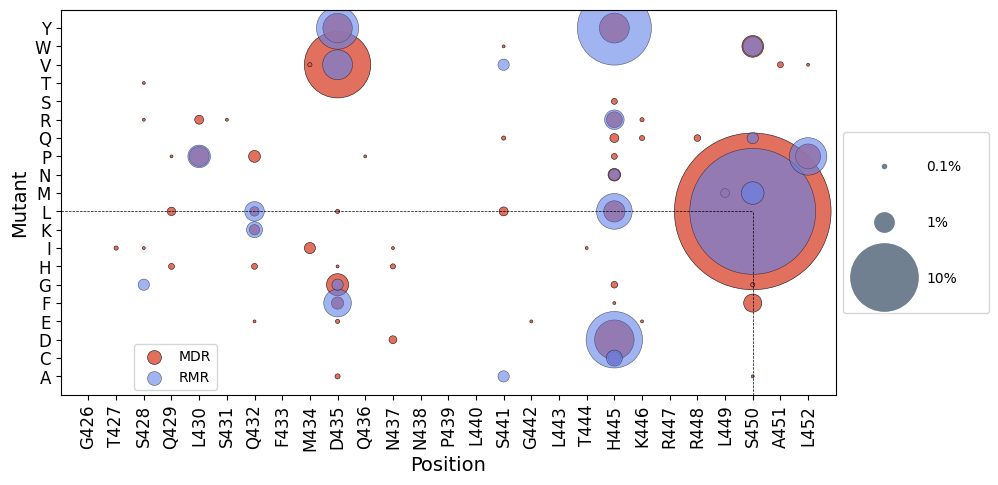

In [114]:
#make graph showing difference in rpoB RRDR mutational profile for RMR and MDR isolates

plt.figure(figsize=(10,5))

x1=get_position(mdr_rrdr_vcs.index)
y1=get_aa_values(get_new_aa(mdr_rrdr_vcs.index))
s1=((mdr_rrdr_vcs/mdr_muts.UNIQUEID.nunique()))
x2=get_position(monoR_rrdr_vcs.index)
y2=get_aa_values(get_new_aa(monoR_rrdr_vcs.index))
s2=((monoR_rrdr_vcs/monoR_muts.UNIQUEID.nunique()))

scatter1=plt.scatter(x1,y1,s=s1*20000,
                     color='#de604d', alpha=0.9, edgecolors='k', linewidth=0.4,
                     label='MDR')
scatter2=plt.scatter(x2,y2,s=s2*20000, 
                     color='#6282ea', alpha=0.6, edgecolors='k', linewidth=0.4,
                     label='RMR')

for i in range(len(s1)):
    if s1[i]>0.5:
        plt.hlines(y=y1[i],xmin=425, xmax=x1[i], color='k', lw=0.5, linestyle='dashed')
        plt.vlines(x=x1[i],ymin=0, ymax=y1[i], color='k', lw=0.5, linestyle='dashed')
for i in range(len(s2)):
    if s2[i]>0.5 and s2.index[i]!='S450L':
        plt.hlines(y=y2[i],xmin=425, xmax=x2[i], color='k', lw=0.5, linestyle='dashed')
        plt.vlines(x=x2[i],ymin=0, ymax=y2[i], color='k', lw=0.5, linestyle='dashed')

plt.xlim([425, 453])    
plt.ylim([0, 21]) 
plt.xticks(range(426,453), ['G426','T427','S428','Q429','L430','S431','Q432','F433','M434','D435','Q436','N437','N438',
                           'P439','L440','S441','G442','L443','T444','H445','K446','R447','R448','L449','S450','A451',
                            'L452'],rotation='vertical')
plt.xlabel('Position')
plt.ylabel('Mutant')

index_list=[]
for a in aas_dict.keys():
    index_list.append(a)
plt.yticks(range(1,21), index_list[:-2])


legend1 = plt.legend( bbox_to_anchor=(0.21, 0.15))
legend1.legendHandles[0]._sizes = [100]
legend1.legendHandles[1]._sizes = [100]
plt.gca().add_artist(legend1)




line1 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.001*20000)/3.14159))*2, 
                     markerfacecolor="slategray")
line2 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.01*20000)/3.14159))*2, 
                     markerfacecolor="slategray")
line3 = lines.Line2D(range(1), range(1), color="white", marker='o',markersize=(np.sqrt((0.1*20000)/3.14159))*2, 
                     markerfacecolor="slategray")
plt.legend((line1,line2,line3),('0.1%','1%', '10%'),numpoints=1, bbox_to_anchor=(1, 0.7), 
           labelspacing=3, borderpad=2, handletextpad=2)

fig.tight_layout()
plt.savefig('rrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')

In [115]:
#value_counts of non-synonymous rpoB mutations outside the RRDR in RMR and MDR isolates
monoR_nonrrdr_vcs=monoR_muts.loc[(monoR_muts['IS_SYNONYMOUS']==False)&
                                        (monoR_muts['IS_HET']==False)&
                                        (monoR_muts['IS_FILTER_PASS']==True)&
                                        (monoR_muts['IS_NULL']==False)&
                                        ((monoR_muts['POSITION']<426)|(monoR_muts['POSITION']>452))
                                            ].MUTATION.value_counts()

mdr_nonrrdr_vcs=mdr_muts.loc[(mdr_muts['IS_SYNONYMOUS']==False)&
                                        (mdr_muts['IS_HET']==False)&
                                        (mdr_muts['IS_FILTER_PASS']==True)&
                                        (mdr_muts['IS_NULL']==False)&
                                        ((mdr_muts['POSITION']<426)|(mdr_muts['POSITION']>452))
                                            ].MUTATION.value_counts()

<ipython-input-116-1739174fff0e>:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
<ipython-input-116-1739174fff0e>:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('non-rrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True)


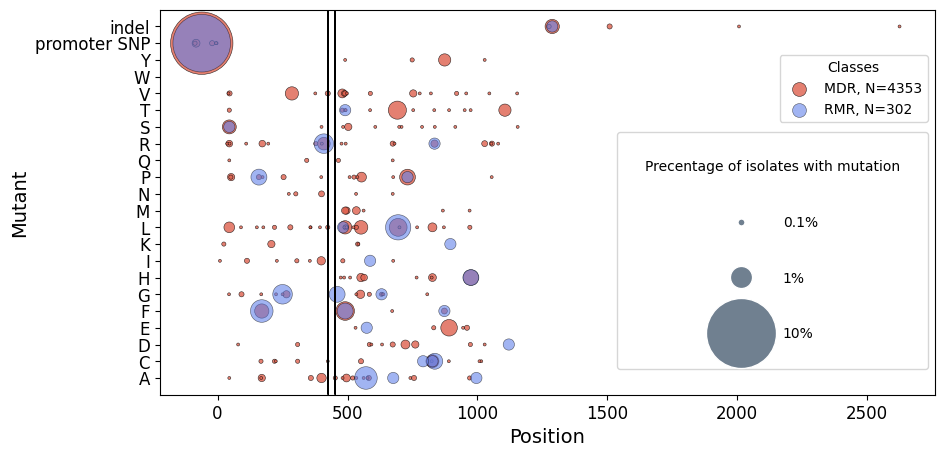

In [116]:
#make graph showing difference in rpoB mutational profile outside the RRDR for RMR and MDR isolates

plt.figure(figsize=(10,5))

x1=get_position(mdr_nonrrdr_vcs.index)
y1=get_aa_values(get_new_aa(mdr_nonrrdr_vcs.index))

x2=get_position(monoR_nonrrdr_vcs.index)
y2=get_aa_values(get_new_aa(monoR_nonrrdr_vcs.index))

plt.scatter(x1,y1,
            s=((mdr_nonrrdr_vcs/mdr_muts.UNIQUEID.nunique()))*20000,color='#de604d', alpha=0.8, edgecolors='k',linewidth=0.4,
            label='MDR, N='+str(mdr_muts.UNIQUEID.nunique()))
plt.scatter(x2,y2,
            s=((monoR_nonrrdr_vcs/monoR_muts.UNIQUEID.nunique()))*20000, color= '#6282ea', alpha=0.6, edgecolors='k',linewidth=0.4,
            label='RMR, N='+str(monoR_muts.UNIQUEID.nunique()))

plt.arrow(425.5,0,0,23)
plt.arrow(452.5,0,0,23)
plt.ylim(0,23)
plt.yticks(range(1,23), aas_dict.keys())
plt.xlabel('Position')
plt.ylabel('Mutant')

# produce a legend with the unique colors from the scatter
legend1 = plt.legend(title="Classes", loc='upper right', bbox_to_anchor=(1, 0.9))
legend1.legendHandles[0]._sizes = [100]
legend1.legendHandles[1]._sizes = [100]
plt.gca().add_artist(legend1)
# produce a legend with a cross section of sizes from the scatter


line1 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.001*20000)/3.14159))*2, 
                     markerfacecolor="slategray")
line2 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.01*20000)/3.14159))*2, 
                     markerfacecolor="slategray")
line3 = lines.Line2D(range(1), range(1), color="white", marker='o',markersize=(np.sqrt((0.1*20000)/3.14159))*2, 
                     markerfacecolor="slategray")
plt.legend((line1,line2,line3),('0.1%','1%', '10%'),numpoints=1, bbox_to_anchor=(1, 0.7), 
           labelspacing=3, title="Precentage of isolates with mutation", borderpad=2, handletextpad=2)
fig.tight_layout()
plt.savefig('non-rrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True)